In [1]:
import marimo as mo

## Creating tools

In [2]:
from langchain.tools import tool

### Web search

In [3]:
from ddgs import DDGS
from loguru import logger

In [4]:
DDGSResult = list[dict[str, str]]

@tool
def search(
    query: str,
    max_results: int = 10,
    region: str = "us-en",
    safesearch: str = "moderate",
    timelimit: str | None = None,
    page: int = 1,
    backend: str = "auto",
) -> DDGSResult | str:
    """
    DuckDuckGo text search for web pages, articles, and information.

    Args:
        query: text search query.
        region: us-en, uk-en, ru-ru, etc. Defaults to us-en.
        safesearch: on, moderate, off. Defaults to "moderate".
        timelimit: d, w, m, y. Defaults to None.
        max_results: maximum number of results. Defaults to 10.
        page: page of results. Defaults to 1.
        backend: A single or comma-delimited backends. Defaults to "auto".
    Returns:
        List of dictionaries with search results.
    """
    logger.info(f"search: {query[:50]}...")
    results = DDGS().text(
        query=query,
        region=region,
        safesearch=safesearch,
        timelimit=timelimit,
        max_results=max_results,
        page=page,
        backend=backend,
    )
    logger.info(f"search: {len(results)} results")
    return results

### Arxiv search

In [5]:
import arxiv

In [6]:
@tool
def arxiv_search(query: str, max_results: int = 3) -> list[dict]:
    """Search for relevant papers using the arXiv tool"""
    logger.info(f"arxiv_search: {query[:50]}...")
    search = arxiv.Search(
        query=query, max_results=max_results, sort_by=arxiv.SortCriterion.Relevance
    )

    papers = []
    for result in search.results():
        papers.append(
            {
                "title": result.title,
                "authors": [author.name for author in result.authors],
                "summary": result.summary,
                "published": result.published.isoformat(),
                "url": result.entry_id,
                "arxiv_id": result.entry_id.split("/")[-1],
            }
        )

    logger.info(f"arxiv_search: {len(papers)} papers")
    return papers

## Pydantic models and State

In [7]:
import operator
from textwrap import dedent
from typing import Annotated

from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

In [8]:
class ResearchQuery(BaseModel):
    topic: str = Field(..., description="Research topic to investigate")
    max_papers: int = Field(
        default=5, description="Maximum number of arXiv papers to retrieve"
    )
    max_web_results: int = Field(
        default=5, description="Maximum number of web results to retrieve"
    )
    year_filter: str | None = Field(
        default=None, description="Optional year filter for papers"
    )

class ResearchPlan(BaseModel):
    arxiv_query: str = Field(..., description="Formatted query for arXiv search")
    web_queries: list[str] = Field(..., description="List of web search queries")
    focus_areas: list[str] = Field(
        ..., description="Key focus areas for the research"
    )

class ArxivFinding(BaseModel):
    title: str = Field(..., description="Title of the paper")
    authors: list[str] = Field(..., description="List of author names")
    summary: str = Field(..., description="Summary of the paper")
    url: str = Field(..., description="ArXiv URL")
    published: str = Field(..., description="Publication date")

class ArxivFindings(BaseModel):
    papers: list[ArxivFinding] = Field(
        default_factory=list, description="List of found arXiv papers"
    )

class WebFinding(BaseModel):
    title: str = Field(..., description="Title of the web source")
    url: str = Field(..., description="URL of the web source")
    content_summary: str = Field(..., description="Summary of the content")

class WebFindings(BaseModel):
    sources: list[WebFinding] = Field(
        default_factory=list, description="List of found web sources"
    )

class ResearchReport(BaseModel):
    topic: str = Field(..., description="Research topic")
    key_findings: list[str] = Field(..., description="List of key findings")
    summary: str = Field(..., description="Overall summary of the research")
    gaps_identified: list[str] = Field(
        default_factory=list, description="Identified research gaps"
    )

class ReviewFeedback(BaseModel):
    approved: bool = Field(..., description="Whether the report is approved")
    missing_aspects: list[str] = Field(
        default_factory=list, description="Missing aspects in the report"
    )
    quality_score: float = Field(..., description="Quality score (0.0-1.0)")
    suggestions: list[str] = Field(
        default_factory=list, description="Suggestions for improvement"
    )

class ResearchState(BaseModel):
    query: ResearchQuery
    plan: ResearchPlan | None = None
    arxiv_findings: Annotated[list[ArxivFinding], operator.add] = Field(
        default_factory=list
    )
    web_findings: Annotated[list[WebFinding], operator.add] = Field(
        default_factory=list
    )
    report: ResearchReport | None = None
    review: ReviewFeedback | None = None
    errors: Annotated[list[str], operator.add] = Field(default_factory=list)
    iteration: int = 0

## Graph

In [9]:
from langchain.agents import create_agent
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from langgraph.types import RetryPolicy

In [10]:
import os

from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv(usecwd=True))

BASE_URL = os.getenv("OPENAI_BASE_URL", "http://a6k2.dgx:34000/v1")
API_KEY = os.getenv("OPENAI_API_KEY", "")
MODEL_NAME = os.getenv("MODEL_NAME", "qwen3-32b")

In [11]:
llm = ChatOpenAI(
    base_url=BASE_URL,
    api_key=API_KEY,
    model=MODEL_NAME,
)

### Prompts

In [12]:
# Create parsers
planner_parser = PydanticOutputParser(pydantic_object=ResearchPlan)
arxiv_parser = PydanticOutputParser(pydantic_object=ArxivFindings)
web_parser = PydanticOutputParser(pydantic_object=WebFindings)
synthesizer_parser = PydanticOutputParser(pydantic_object=ResearchReport)
reviewer_parser = PydanticOutputParser(pydantic_object=ReviewFeedback)

# Planner prompt
PLANNER_PROMPT = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            dedent(
                """
        You are a research coordinator. Your task is to analyze the research topic and create a structured research plan.

        Based on the user's topic, generate:
        1. A well-formulated arXiv query
        2. Multiple web search queries to cover different aspects
        3. Key focus areas for the research
        4. Expected number of sources

        Be specific and thorough in your planning.

        {format_instructions}
        /no_think
    """
            ).strip(),
        ),
        (
            "human",
            dedent(
                """
        Topic: {topic}
        Max papers: {max_papers}
        Max web results: {max_web_results}
    """
            ).strip(),
        ),
    ]
)

# ArXiv researcher prompt (for agent)
ARXIV_SEARCH_PROMPT = dedent(
    """
    You are an academic researcher specializing in analyzing arXiv papers.

    Your task is to:
    1. Search for relevant papers using the arXiv tool
    2. Extract key information from each paper
    3. Summarize the main contributions
    4. Identify the most important papers for the research topic

    Focus on recent, high-quality publications. Use the available tools to search arXiv.
"""
).strip()

# ArXiv parser prompt
ARXIV_PARSER_PROMPT = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            dedent(
                """
        You are a helpful assistant that extracts paper information from agent search results.
        {format_instructions}
        /no_think
    """
            ).strip(),
        ),
        (
            "human",
            dedent(
                """
        Extract papers from these agent results:

        {agent_output}
    """
            ).strip(),
        ),
    ]
)

# Web researcher prompt (for agent)
WEB_SEARCH_PROMPT = dedent(
    """
    You are a web researcher specializing in finding and analyzing online sources.

    Your task is to:
    1. Search the web using the DuckDuckGo tool
    2. Extract and summarize relevant content
    3. Assess the relevance and quality of each source
    4. Provide concise summaries of key findings

    Focus on authoritative and up-to-date sources. Use the available tools to search the web.
"""
).strip()

# Web parser prompt
WEB_PARSER_PROMPT = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            dedent(
                """
        You are a helpful assistant that extracts web source information from agent search results.
        {format_instructions}
        /no_think
    """
            ).strip(),
        ),
        (
            "human",
            dedent(
                """
        Extract web sources from these agent results:

        {agent_output}
    """
            ).strip(),
        ),
    ]
)

# Synthesizer prompt
SYNTHESIZER_PROMPT = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            dedent(
                """
        You are a research analyst and technical writer.

        Your task is to synthesize all collected research into a comprehensive report.

        You should:
        1. Identify and summarize key findings across all sources
        2. Write a coherent summary of the research landscape
        3. Highlight important papers and sources
        4. Identify gaps in current research or understanding

        Create a well-structured, informative research report.

        {format_instructions}
        /no_think
    """
            ).strip(),
        ),
        (
            "human",
            dedent(
                """
        {context}
    """
            ).strip(),
        ),
    ]
)

# Reviewer prompt
REVIEWER_PROMPT = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            dedent(
                """
        You are a critical reviewer and research quality assessor.

        Your task is to evaluate the research report for:
        1. Completeness - are all important aspects covered?
        2. Quality - is the analysis thorough and well-reasoned?
        3. Clarity - is the report well-written and understandable?
        4. Missing aspects - what could be improved or added?

        Provide a quality score (0.0-1.0) and decide if the report is approved or needs revision.
        Be strict but fair in your assessment.

        {format_instructions}
        /no_think
    """
            ).strip(),
        ),
        (
            "human",
            dedent(
                """
        {report_text}
    """
            ).strip(),
        ),
    ]
)

### Structure

In [13]:
arxiv_agent = create_agent(llm, [arxiv_search], system_prompt=ARXIV_SEARCH_PROMPT)
web_agent = create_agent(llm, [search], system_prompt=WEB_SEARCH_PROMPT)

In [14]:
async def planner_node(state):
    logger.info(f"planner: {state.query.topic}")
    messages = PLANNER_PROMPT.format_messages(
        format_instructions=planner_parser.get_format_instructions(),
        topic=state.query.topic,
        max_papers=state.query.max_papers,
        max_web_results=state.query.max_web_results,
    )
    response = await llm.ainvoke(messages)
    plan = planner_parser.parse(response.content)
    logger.info(f"planner: {len(plan.web_queries)} queries")
    return {"plan": plan}

In [15]:
async def arxiv_researcher_node(state):
    if not state.plan:
        raise ValueError("No research plan available")

    query = state.plan.arxiv_query
    max_papers = state.query.max_papers
    logger.info(f"arxiv_researcher: {query[:50]}...")

    message = HumanMessage(
        content=f"Search arXiv for: '{query}'. Find up to {max_papers} relevant papers."
    )
    agent_response = await arxiv_agent.ainvoke({"messages": [message]})
    agent_output = agent_response["messages"][-1].content

    chain = ARXIV_PARSER_PROMPT | llm | arxiv_parser
    parsed_result = await chain.ainvoke(
        {
            "format_instructions": arxiv_parser.get_format_instructions(),
            "agent_output": agent_output,
        }
    )

    logger.info(f"arxiv_researcher: {len(parsed_result.papers)} papers")
    return {"arxiv_findings": parsed_result.papers}

In [16]:
async def web_researcher_node(state):
    if not state.plan:
        raise ValueError("No research plan available")

    queries = " AND ".join(state.plan.web_queries)
    max_results = state.query.max_web_results
    logger.info(f"web_researcher: {queries[:50]}...")

    message = HumanMessage(
        content=f"Search web for: {queries}. Find up to {max_results} relevant sources."
    )
    agent_response = await web_agent.ainvoke({"messages": [message]})
    agent_output = agent_response["messages"][-1].content

    chain = WEB_PARSER_PROMPT | llm | web_parser
    parsed_result = await chain.ainvoke(
        {
            "format_instructions": web_parser.get_format_instructions(),
            "agent_output": agent_output,
        }
    )

    logger.info(f"web_researcher: {len(parsed_result.sources)} sources")
    return {"web_findings": parsed_result.sources}

In [17]:
async def synthesizer_node(state):
    logger.info(f"synthesizer: iter={state.iteration}")
    arxiv_summary = "\n".join(
        [
            f"- {p.title} by {', '.join(p.authors)}: {p.summary}"
            for p in state.arxiv_findings
        ]
    )
    web_summary = "\n".join(
        [f"- {s.title} ({s.url}): {s.content_summary}" for s in state.web_findings]
    )

    feedback = ""
    if state.review and state.review.suggestions:
        feedback = "Previous review feedback: " + ", ".join(
            state.review.suggestions
        )

    context = f"""Topic: {state.query.topic}

ArXiv Papers:
{arxiv_summary if arxiv_summary else "No papers found"}

Web Sources:
{web_summary if web_summary else "No sources found"}

{feedback}"""

    messages = SYNTHESIZER_PROMPT.format_messages(
        format_instructions=synthesizer_parser.get_format_instructions(),
        context=context,
    )
    response = await llm.ainvoke(messages)
    report = synthesizer_parser.parse(response.content)
    logger.info(f"synthesizer: {len(report.key_findings)} findings")
    return {"report": report, "iteration": state.iteration + 1}

In [18]:
async def reviewer_node(state):
    if not state.report:
        raise ValueError("No report available to review")

    logger.info("reviewer: evaluating report")
    report_text = f"""Report Summary: {state.report.summary}
Key Findings: {", ".join(state.report.key_findings)}
Number of ArXiv papers: {len(state.arxiv_findings)}
Number of Web sources: {len(state.web_findings)}
Gaps identified: {", ".join(state.report.gaps_identified)}"""

    messages = REVIEWER_PROMPT.format_messages(
        format_instructions=reviewer_parser.get_format_instructions(),
        report_text=report_text,
    )
    response = await llm.ainvoke(messages)
    review = reviewer_parser.parse(response.content)
    logger.info(
        f"reviewer: approved={review.approved}, score={review.quality_score:.2f}"
    )
    return {"review": review}

In [19]:
def should_revise(state) -> str:
    if state.review and not state.review.approved and state.iteration < 2:
        return "synthesizer"
    return "end"

In [20]:
g = StateGraph(ResearchState)

In [21]:
retry_policy = RetryPolicy(
    max_attempts=3,
    initial_interval=0.5,
    backoff_factor=2.0,
    jitter=True,
)

g.add_node("planner", planner_node)
g.add_node("arxiv_researcher", arxiv_researcher_node, retry=retry_policy)
g.add_node("web_researcher", web_researcher_node, retry=retry_policy)
g.add_node("synthesizer", synthesizer_node)
g.add_node("reviewer", reviewer_node)

g.set_entry_point("planner")

g.add_edge("planner", "arxiv_researcher")
g.add_edge("planner", "web_researcher")

g.add_edge("arxiv_researcher", "synthesizer")
g.add_edge("web_researcher", "synthesizer")

g.add_edge("synthesizer", "reviewer")

g.add_conditional_edges(
    "reviewer", should_revise, {"synthesizer": "synthesizer", "end": END}
)

app = g.compile()

## Graph Visualization

In [29]:
from IPython.display import Image, display

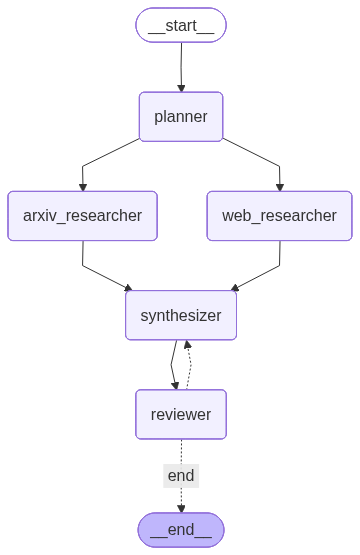

In [32]:
b = app.get_graph().draw_mermaid_png()
Image(data=b)

## Demo Execution

In [23]:
QUERY = "Multi-agent systems with LLMs"

In [24]:
demo_query = ResearchQuery(
    topic=QUERY,
    max_papers=3,
    max_web_results=3,
)

In [25]:
state = ResearchState(query=demo_query)
result = await app.ainvoke(state)

2025-11-21 21:27:04.820 | INFO     | __main__:planner_node:2 - planner: Multi-agent systems with LLMs
2025-11-21 21:27:04.854 | INFO     | __main__:planner_node:11 - planner: 3 queries
2025-11-21 21:27:04.855 | INFO     | __main__:arxiv_researcher_node:7 - arxiv_researcher: multi-agent systems AND large language models...
2025-11-21 21:27:04.856 | INFO     | __main__:web_researcher_node:7 - web_researcher: multi-agent systems with LLMs use cases AND LLM-ba...
2025-11-21 21:27:04.889 | INFO     | __main__:arxiv_search:4 - arxiv_search: multi-agent systems AND large language models...
/tmp/ipykernel_308689/3895691407.py:10: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():
2025-11-21 21:27:04.900 | INFO     | __main__:search:27 - search: multi-agent systems with LLMs use cases AND LLM-ba...
2025-11-21 21:27:05.138 | INFO     | __main__:arxiv_search:22 - arxiv_search: 3 papers
2025-11-21 21:27:05.193 | INFO     | 

In [26]:
result

{'query': ResearchQuery(topic='Multi-agent systems with LLMs', max_papers=3, max_web_results=3, year_filter=None),
 'plan': ResearchPlan(arxiv_query='multi-agent systems AND large language models', web_queries=['multi-agent systems with LLMs use cases', 'LLM-based multi-agent system collaboration strategies', 'challenges in deploying LLMs in multi-agent environments'], focus_areas=['Collaborative decision-making in multi-agent systems using LLMs', 'Integration of LLMs for communication and coordination', 'Scalability and performance considerations in multi-agent LLM systems']),
 'arxiv_findings': [ArxivFinding(title='Augmenting the action space with conventions to improve multi-agent cooperation in Hanabi', authors=['F. Bredell', 'H. A. Engelbrecht', 'J. C. Schoeman'], summary="Focuses on improving cooperation in the game *Hanabi* using conventions (predefined rules for implicit communication). Proposes augmenting agents' action spaces with multi-step, cooperative conventions inspired 

In [27]:
result.get("report")

ResearchReport(topic='Multi-agent systems with LLMs', key_findings=['Augmenting the action space with predefined conventions in cooperative games like *Hanabi* significantly enhances multi-agent cooperation, especially in self-play and cross-play scenarios.', 'Communication mechanisms in multi-agent deep reinforcement learning (Comm-MADRL) can be systematically classified along 9 dimensions, including communication content, topology, and learning paradigms.', 'Dynamic activation/deactivation methodologies for multi-level agent-based simulations enable efficient modeling of complex systems across scales while managing computational resources.', 'LLMs can enhance scene understanding and decision-making in autonomous driving multi-agent systems, but challenges persist in integrating text-based perception and ensuring real-time collaboration.', 'LLM-based multi-agent systems face stability issues and require effective collaboration strategies to function cohesively in complex environments.